# Presidential Election

Main aim of this project to learn how to deal with GDELT data and make a basic US election prediction model 

# Resources
* https://analysis.gdeltproject.org/

* https://towardsdatascience.com/polls-and-press-ef340199e425

* https://github.com/sgodfrey66/Polls_and_press/blob/master/code/Google_BigQuery.ipynb

* https://nbviewer.jupyter.org/github/JamesPHoughton/Published_Blog_Scripts/blob/master/GDELT%20Wrangler%20-%20Clean.ipynb

* https://fivethirtyeight.com/

# Accessing GDELT data without Google Bigquery
https://pypi.org/project/gdelt/

In [ ]:
!pip install gdelt

     |████████████████████████████████| 778kB 7.5MB/s 


# GDELT Data

Average daily data size is about 1.5GB

If coverage is true, it collects all 15 mins data from GDELT, else it only collects daily 11:45PM data

Gets total new cound and avg tone data for selected names and dates

In [ ]:
import gdelt
import pandas as pd
import numpy as np
import datetime

gd2 = gdelt.gdelt(version = 2)
# gkg = gd2.Search(['2016 08 01', '2016 08 05'], table = 'gkg', coverage = True)
gkg = gd2.Search(['2016 06 01', '2016 10 31'], table = 'gkg')

In [ ]:
#gkg[gkg["V2Locations"].notnull()].query("V2Locations.str.contains('US#')", engine = "python")

# 2020 Presidential and VP candicates
# df.query("V2Persons.str.contains('Biden') or V2Persons.str.contains('Trump') or V2Persons.str.contains('Kamala') or V2Persons.str.contains('Pence')", engine = "python", inplace = True)

# 2016 Democrat candidate and VP filter
# Extracting Tone column's list to new columns
dem = gkg.query("V2Persons.str.contains('Clinton') or V2Persons.str.contains('Kaine')", engine = "python")
dem[["Tone", "Positive Score", "Negative Score", "Polarity", "Activity Ref. Den.", "Self_Group Ref. Den.", "WordCount"]] = pd.DataFrame(dem["V2Tone"].str.split(",").tolist(), index = dem.index)
dem["Tone"] = dem["Tone"].astype("float")

# Extract state info
dem["Locations"].fillna("####0#0#", inplace = True)
dem["Country"] = dem["Locations"].apply(lambda x: str(str(x).split(";")[0]).split("#")[2])
dem["State"] = dem["Locations"].apply(lambda x: str(str(x).split(";")[0]).split("#")[3])

dem = dem[dem["Country"] == "US"].reset_index()
#sumd = dem.groupby(["DATE", "State"]).agg(dem_count = ("DATE", "count"), dem_tone = ("Tone", "mean")).reset_index()
sumd = dem.groupby(["DATE", "State"]).agg(news_count = ("DATE", "count"), news_tone = ("Tone", "mean")).reset_index()
sumd["party_type"] = 1 # Democrat

# 2016 Republican candidate and VP filter
# Extracting Tone column's list to new columns
rep = gkg.query("V2Persons.str.contains('Trump') or V2Persons.str.contains('Pence')", engine = "python")
rep[["Tone", "Positive Score", "Negative Score", "Polarity", "Activity Ref. Den.", "Self_Group Ref. Den.", "WordCount"]] = pd.DataFrame(rep["V2Tone"].str.split(",").tolist(), index = rep.index)
rep["Tone"] = rep["Tone"].astype("float")

# Extract state info
rep["Locations"].fillna("####0#0#", inplace = True)
rep["Country"] = rep["Locations"].apply(lambda x: str(str(x).split(";")[0]).split("#")[2])
rep["State"] = rep["Locations"].apply(lambda x: str(str(x).split(";")[0]).split("#")[3])

rep = rep[rep["Country"] == "US"].reset_index()
#sumr = rep.groupby(["DATE", "State"]).agg(rep_count = ("DATE", "count"), rep_tone = ("Tone", "mean")).reset_index()
sumr = rep.groupby(["DATE", "State"]).agg(news_count = ("DATE", "count"), news_tone = ("Tone", "mean")).reset_index()
sumr["party_type"] = 2 # Republican

# Summarized GDELT Data
# Candidate results are in columns
#sumg = pd.merge(sumd, sumr, on = ["DATE", "State"], how = "outer")
#sumg["DATE"] = [datetime.datetime.strptime(x[:8], "%Y%m%d") for x in sumg["DATE"].astype("str")]

#sumg["WeekNumber"] = sumg.DATE.dt.week
#weekly_sumg = sumg.groupby(["WeekNumber", "State"]).agg(total_dem_news = ("dem_count", "sum"), total_rep_news = ("rep_count", "sum"), 
#                                          avg_dem_tone = ("dem_tone", "mean"), avg_rep_tone = ("rep_tone", "mean")).reset_index()

# Summarized GDELT Data
# Candidate results are in rows
sumg = sumr.append(sumd)
sumg["DATE"] = [datetime.datetime.strptime(x[:8], "%Y%m%d") for x in sumg["DATE"].astype("str")]

sumg["WeekNumber"] = sumg.DATE.dt.week
weekly_sumg = sumg.groupby(["WeekNumber", "State", "party_type"]).agg(total_news = ("news_count", "sum"), avg_tone = ("news_tone", "mean")).reset_index()

!!!!!NOT COMPLETED!!!!!

Daily Avg tone and news count retrival function

GDELT library requires minimum 2 days to retrieve data

In [ ]:
def daily_cand_counts(start_date, end_date, dem1, dem2, rep1, rep2):
  """
  Gets daily data from GDELT with 15 min intervals. Counts articles and mean of articles' tone for input names
  """
  import gdelt
  import pandas as pd
  import datetime
  
  gd2 = gdelt.gdelt(version = 2)
  sd = datetime.datetime.strptime(start_date, '%Y%m%d')
  ed = datetime.datetime.strptime(end_date, '%Y%m%d')

  # Date, candidate, article count, tone
  daily_cand = []

  while start_date <= end_date:
    gkg = gd2.Search([start_date, start_date + timedelta(days = 1)], table = 'gkg', coverage = True)
    cand = gkg.query("V2Persons.str.contains('" + dem1 + "') or V2Persons.str.contains('" + dem2 + "')", engine = "python")
    cand[["Tone", "Positive Score", "Negative Score", "Polarity", "Activity Ref. Den.", "Self_Group Ref. Den.", "WordCount"]] = pd.DataFrame(cand["V2Tone"].str.split(",").tolist(), index = cand.index)
    daily_cand.append([start_date, dem1, cand.count(), cand.Tone.mean()])
    del cand

    cand = gkg.query("V2Persons.str.contains('" + rep1 + "') or V2Persons.str.contains('" + rep2 + "')", engine = "python")
    cand[["Tone", "Positive Score", "Negative Score", "Polarity", "Activity Ref. Den.", "Self_Group Ref. Den.", "WordCount"]] = pd.DataFrame(cand["V2Tone"].str.split(",").tolist(), index = cand.index)
    daily_cand.append([start_date, rep1, cand.count(), cand.Tone.mean()])
    del cand
    del gkg

    start_date = start_date + timedelta(days = 1)
  return daily_cand

# Poll Data

Data is collected from https://github.com/fivethirtyeight/data/tree/master/polls

Data source for 2016: https://github.com/fivethirtyeight/data/blob/master/polls/pres_pollaverages_1968-2016.csv

In [ ]:
!pip install -U -q PyDrive

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import io
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = "1nGNmW6bKM17pSO28DpSG40hFKKh5tp_h"
downloaded = drive.CreateFile({"id": file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
pdf = pd.read_csv(io.StringIO(downloaded.GetContentString("text/csv")))

Import US State codes from Google Sheets

Generated from: https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes

In [ ]:
file_id = "1827sqdSi7z99xZAxR01TkUdvxZRnxroQ_HEydS5shXA"
downloaded = drive.CreateFile({"id": file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
usc = pd.read_csv(io.StringIO(downloaded.GetContentString("text/csv")))
usc.columns = ["State",	"Abbreviation", "PostalCode", "GDELTCODE"]
usc["StateID"] = range(1, 1 + len(usc))

!!!!!V2 Improvements!!!!!

Needed to import electoral collage counts by state to rank states

Also data can be split into 2 groups,
*   Swing states
*   Stable states




# Combining GDELT with Poll Data

In [ ]:
import matplotlib.pyplot as plt
import seaborn

In [ ]:
# Filtering last year only
pdf = pdf[pdf["cycle"] == 2016]

# Filtering poll data's month
pdf.modeldate = pdf.modeldate.astype("datetime64")
pdf = pdf[(pdf["modeldate"] >= '2016-06-01') & (pdf["modeldate"] <= '2016-10-31')]

# Filtering for candidates
pdf = pdf[(pdf["candidate_name"] == "Donald Trump") | (pdf["candidate_name"] == "Hillary Rodham Clinton")]

#pdf.hist(figsize = (20, 15))

In [ ]:
# Summarized Poll Data
# Candidate results are in columns
#pct_est = pd.pivot_table(pdf, values = "pct_estimate", index = ["modeldate", "state"], columns = "candidate_name").reset_index()
#pct_est.columns = ["DATE", "State", "rep_pct", "dem_pct"]

#pct_trend = pd.pivot_table(pdf, values = "pct_trend_adjusted", index = ["modeldate", "state"], columns = "candidate_name").reset_index()
#pct_trend.columns = ["DATE", "State", "rep_pct_trend", "dem_pct_trend"]

#polls = pd.merge(pct_est, pct_trend, on = ["DATE", "State"], how = "outer")
#polls["WeekNumber"] = polls.DATE.dt.week

#weekly_polls = polls.groupby(["WeekNumber", "State"]).agg(avg_dem_trend = ("dem_pct_trend", "mean"), avg_rep_trend = ("rep_pct_trend", "mean"), 
#                                          avg_dem = ("rep_pct", "mean"), avg_rep = ("dem_pct", "mean")).reset_index()

#poll_usc = pd.merge(usc, weekly_polls, on = "State", how = "outer")
#final_df = pd.merge(weekly_sumg, poll_usc, left_on = ["WeekNumber", "State"], right_on = ["WeekNumber", "GDELTCODE"], how = "outer").reset_index()

# Summarized Poll Data
# Candidate results are in rows
pta = pdf[["modeldate", "state", "candidate_name", "pct_trend_adjusted"]]
pta["modelweek"] = pta.modeldate.dt.week
pta.loc[pta["candidate_name"] == "Hillary Rodham Clinton", "party_type"] = 1 # Democarat
pta.loc[pta["candidate_name"] == "Donald Trump", "party_type"] = 2 # Republican

weekly_polls = pta.groupby(["modelweek", "state", "party_type"]).agg(adj_trend_pct = ("pct_trend_adjusted", "mean")).reset_index()
poll_usc = pd.merge(usc, weekly_polls, left_on = "State", right_on = "state", how = "outer")
final_df = pd.merge(weekly_sumg, poll_usc, left_on = ["WeekNumber", "State", "party_type"], right_on = ["modelweek", "GDELTCODE", "party_type"], how = "outer").reset_index()
final_df = final_df[["StateID", "state", "PostalCode", "party_type", "WeekNumber", "total_news", "avg_tone", "adj_trend_pct"]]

In [ ]:
# Final data cleaning - removing NaN
#final_df.dropna(subset=['PostalCode'])
final_df.dropna(inplace = True)

final_df.describe()

,StateID,party_type,WeekNumber,total_news,avg_tone,adj_trend_pct
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,25.215741,1.501054,33.754041,13.365425,-1.118950,41.092361
std,14.502068,0.500175,6.445919,29.511279,1.841128,7.444289
min,1.000000,1.000000,22.000000,1.000000,-11.475410,4.048433
25%,14.000000,1.000000,28.000000,2.000000,-2.066997,36.149801
50%,25.000000,2.000000,34.000000,4.000000,-1.086697,41.311863
75%,37.000000,2.000000,40.000000,11.000000,-0.019151,44.999887
max,51.000000,2.000000,44.000000,290.000000,5.798208,87.595270


# Xgboost-Lin Reg Implementation

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(final_df[["StateID", "party_type", "total_news", "avg_tone"]], final_df["adj_trend_pct"], test_size = 0.2, random_state = 1101)
X_train, X_test, Y_train, Y_test = train_test_split(final_df[["party_type", "total_news", "avg_tone"]], final_df["adj_trend_pct"], test_size = 0.2, random_state = 1101)

xg_reg = xgb.XGBRegressor(
    objective = 'reg:linear',
    colsample_bytree = 0.5,
    learning_rate = 0.5,
    max_depth = 5,
    alpha = 10,
    n_estimators = 100)

xg_reg.fit(X_train, Y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(Y_test, preds))
"RMSE: %f" % (rmse)

[20:10:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


'RMSE: 8.531900'

In [ ]:
accuracy = accuracy_score(Y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Cross Validition

In [ ]:
#data_dmatrix = xgb.DMatrix(data = final_df[["StateID", "party_type", "total_news", "avg_tone"]], label = final_df["adj_trend_pct"])
data_dmatrix = xgb.DMatrix(data = final_df[["party_type", "total_news", "avg_tone"]], label = final_df["adj_trend_pct"])

params = {
    "objective": "reg:linear",
    "colsample_bytree": 0.5,
    "learning_rate": 0.5,
    "max_depth": 5,
    "alpha": 10,
    "n_estimators": 100}

cv_results = xgb.cv(dtrain = data_dmatrix, params = params, nfold = 3,
                    num_boost_round = 50, early_stopping_rounds = 10, metrics = "rmse", as_pandas = True, seed = 1101)

cv_results["test-rmse-mean"].tail(1)

[20:10:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


8    7.451217
Name: test-rmse-mean, dtype: float64

In [ ]:
xg_reg = xgb.train(params = params, dtrain = data_dmatrix, num_boost_round = 100)

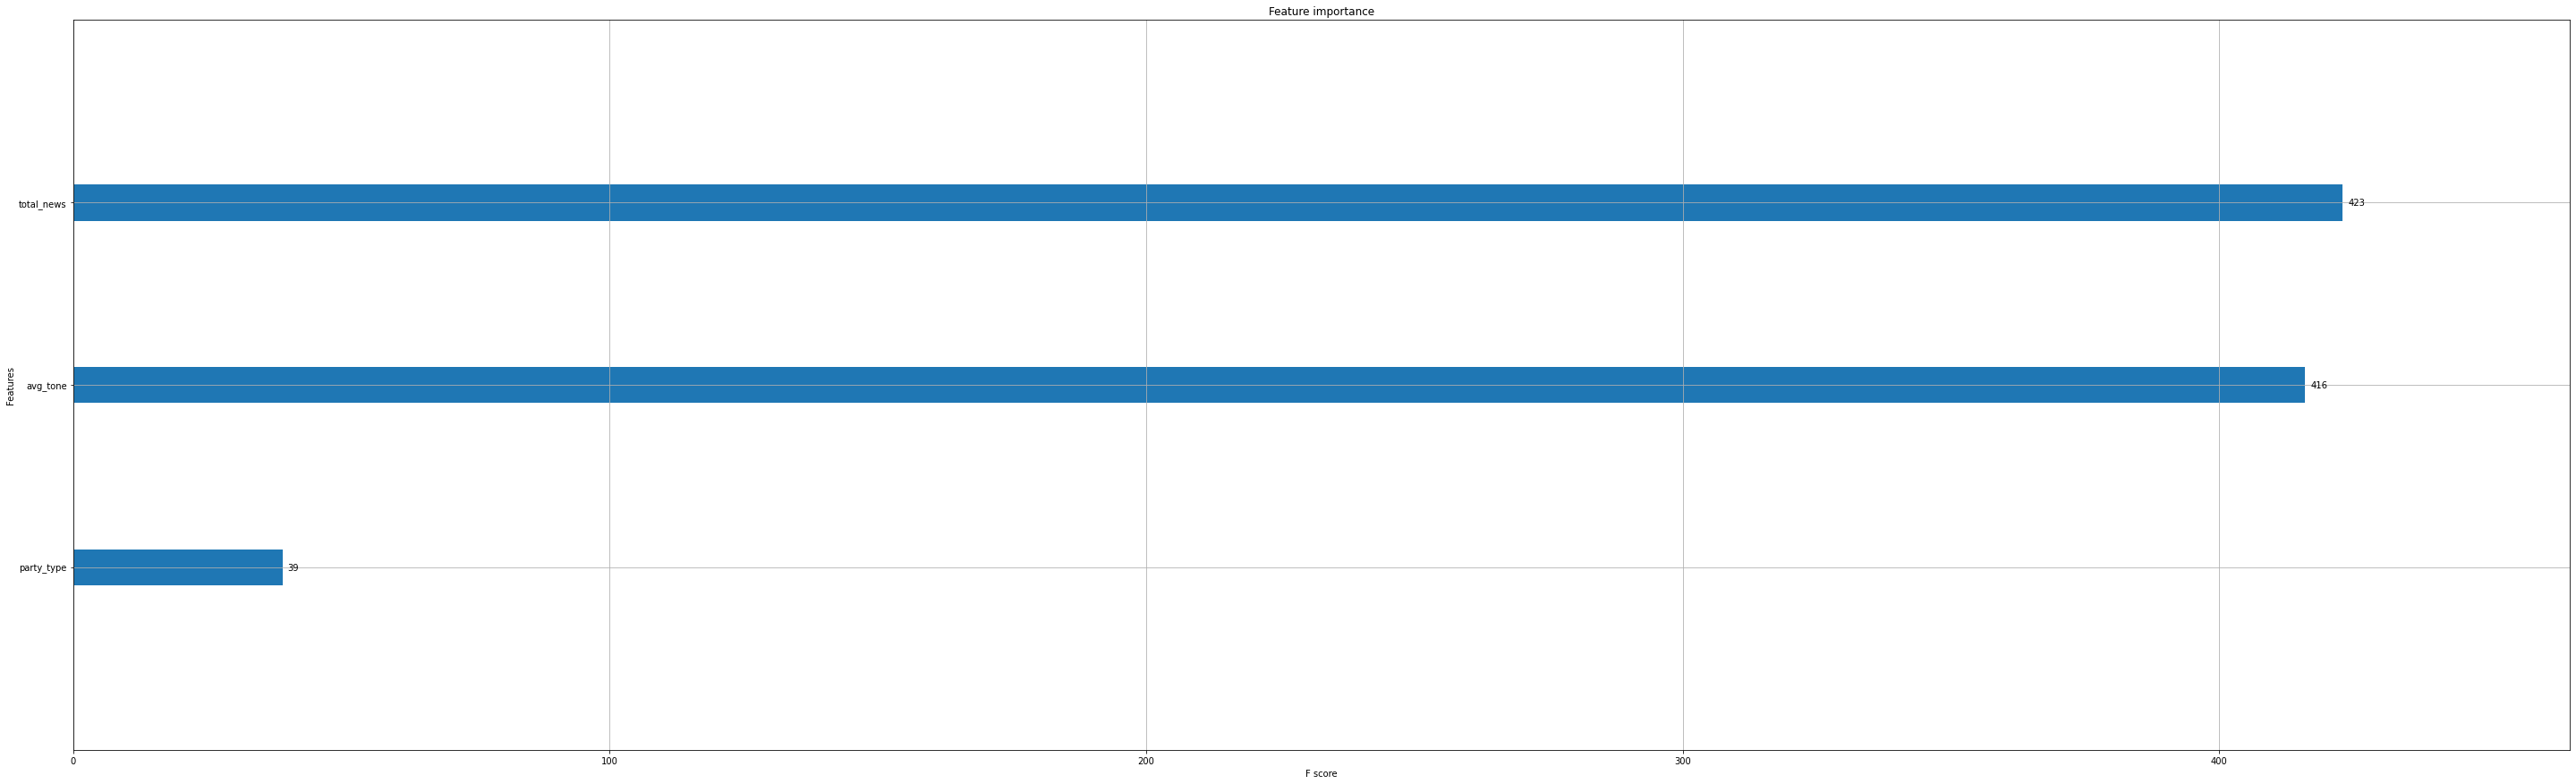

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 15]
plt.show()

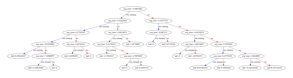

In [ ]:
xgb.plot_tree(xg_reg, num_trees = 5)
plt.rcParams['figure.figsize'] = [50, 15]
plt.show()

Save Model

In [ ]:
import pickle
	
# save model to file
pickle.dump(xg_reg, open("elct_pre_model.dat", "wb"))

xg_reg.save_model("elct_pre_model.model")

# 2020 Poll Predictions

In [ ]:
gkg_2020 = gd2.Search(['2020 06 01', '2020 09 30'], table = 'gkg')

In [ ]:
# 2020 Democrat candidate and VP filter
# Extracting Tone column's list to new columns
dem = gkg.query("V2Persons.str.contains('Biden') or V2Persons.str.contains('Harris')", engine = "python")
dem[["Tone", "Positive Score", "Negative Score", "Polarity", "Activity Ref. Den.", "Self_Group Ref. Den.", "WordCount"]] = pd.DataFrame(dem["V2Tone"].str.split(",").tolist(), index = dem.index)
dem["Tone"] = dem["Tone"].astype("float")

# Extract state info
dem["Locations"].fillna("####0#0#", inplace = True)
dem["Country"] = dem["Locations"].apply(lambda x: str(str(x).split(";")[0]).split("#")[2])
dem["State"] = dem["Locations"].apply(lambda x: str(str(x).split(";")[0]).split("#")[3])

dem = dem[dem["Country"] == "US"].reset_index()
#sumd = dem.groupby(["DATE", "State"]).agg(dem_count = ("DATE", "count"), dem_tone = ("Tone", "mean")).reset_index()
sumd = dem.groupby(["DATE", "State"]).agg(news_count = ("DATE", "count"), news_tone = ("Tone", "mean")).reset_index()
sumd["party_type"] = 1 # Democrat

# 2020 Republican candidate and VP filter
# Extracting Tone column's list to new columns
rep = gkg.query("V2Persons.str.contains('Trump') or V2Persons.str.contains('Pence')", engine = "python")
rep[["Tone", "Positive Score", "Negative Score", "Polarity", "Activity Ref. Den.", "Self_Group Ref. Den.", "WordCount"]] = pd.DataFrame(rep["V2Tone"].str.split(",").tolist(), index = rep.index)
rep["Tone"] = rep["Tone"].astype("float")

# Extract state info
rep["Locations"].fillna("####0#0#", inplace = True)
rep["Country"] = rep["Locations"].apply(lambda x: str(str(x).split(";")[0]).split("#")[2])
rep["State"] = rep["Locations"].apply(lambda x: str(str(x).split(";")[0]).split("#")[3])

rep = rep[rep["Country"] == "US"].reset_index()
#sumr = rep.groupby(["DATE", "State"]).agg(rep_count = ("DATE", "count"), rep_tone = ("Tone", "mean")).reset_index()
sumr = rep.groupby(["DATE", "State"]).agg(news_count = ("DATE", "count"), news_tone = ("Tone", "mean")).reset_index()
sumr["party_type"] = 2 # Republican

# Summarized GDELT Data
# Candidate results are in rows
sumg = sumr.append(sumd)
sumg["DATE"] = [datetime.datetime.strptime(x[:8], "%Y%m%d") for x in sumg["DATE"].astype("str")]

sumg["WeekNumber"] = sumg.DATE.dt.week
weekly_sumg = sumg.groupby(["WeekNumber", "State", "party_type"]).agg(total_news = ("news_count", "sum"), avg_tone = ("news_tone", "mean")).reset_index()
weekly_sumg.drop(weekly_sumg[weekly_sumg["State"] == "US"].index, inplace = True)

In [ ]:
weekly_sumg.head()

,WeekNumber,State,party_type,total_news,avg_tone
2,22,USAL,1,1,-0.702988
3,22,USAL,2,1,-3.191489
4,22,USAR,1,5,-0.962473
5,22,USAR,2,3,-1.660931
6,22,USAZ,2,3,0.734783


In [ ]:
preds = xg_reg.predict(weekly_sumg[["party_type", "total_news", "avg_tone"]])

poll_preds = weekly_sumg[["party_type", "total_news", "avg_tone"]]
poll_preds["adj_trend_pred"] = preds
poll_preds["state"] = weekly_sumg["State"]
poll_preds["weeknumber"] = weekly_sumg["WeekNumber"]
res = pd.merge(usc, poll_preds, left_on = "GDELTCODE", right_on = "state", how = "right")
res = res[["weeknumber", "State", "PostalCode", "party_type", "total_news", "avg_tone", "adj_trend_pred"]]



# 2020 Comparison

2020 Poll Data

Data source for 2020: https://projects.fivethirtyeight.com/2020-general-data/presidential_poll_averages_2020.csv

In [ ]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = "1hjsg9oaEy4gfagHqNzbmr-1PLfdIE7SiMvwG5ar3Vc4"
downloaded = drive.CreateFile({"id": file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
poll_2020 = pd.read_csv(io.StringIO(downloaded.GetContentString("text/csv")))

In [ ]:
# Filtering poll data's month
poll_2020 = poll_2020[poll_2020["cycle"] == 2020]
poll_2020.modeldate = poll_2020.modeldate.astype("datetime64")
poll_2020 = poll_2020[(poll_2020["modeldate"] >= '2020-06-01') & (poll_2020["modeldate"] <= '2020-09-30')]

In [ ]:
p20 = poll_2020[["modeldate", "state", "candidate_name", "pct_trend_adjusted"]]
p20["modelweek"] = p20.modeldate.dt.week
p20.loc[p20["candidate_name"] == "Joseph R. Biden Jr.", "party_type"] = 1 # Democarat
p20.loc[p20["candidate_name"] == "Donald Trump", "party_type"] = 2 # Republican

wp_20 = p20.groupby(["modelweek", "state", "party_type"]).agg(adj_trend_pct = ("pct_trend_adjusted", "mean")).reset_index()

pred_df = pd.merge(res, wp_20, left_on = ["weeknumber", "State", "party_type"], right_on = ["modelweek", "state", "party_type"], how = "outer").reset_index()

In [ ]:
pred_df.head(20)